# Imports

In [248]:
# analysis
import pandas as pd
import numpy as np

# visuals
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler, PolynomialFeatures

# ensemble
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier

%matplotlib inline

# Ensembles

In [249]:
ensembles = {
    'AdaBoostClassifier' : AdaBoostClassifier(random_state=0),
    'ExtraTreesClassifier' : ExtraTreesClassifier(n_estimators=100, random_state=0),
    'RandomForestClassifier' : RandomForestClassifier(n_estimators=100, random_state=0)
}

# Data

In [250]:
# read training data
train = pd.read_csv("train.csv")

In [251]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 7 columns):
id               371 non-null int64
bone_length      371 non-null float64
rotting_flesh    371 non-null float64
hair_length      371 non-null float64
has_soul         371 non-null float64
color            371 non-null object
type             371 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 20.4+ KB


In [252]:
train.describe()

,id,bone_length,rotting_flesh,hair_length,has_soul
count,371.000000,371.000000,371.000000,371.000000,371.000000
mean,443.676550,0.434160,0.506848,0.529114,0.471392
std,263.222489,0.132833,0.146358,0.169902,0.176129
min,0.000000,0.061032,0.095687,0.134600,0.009402
25%,205.500000,0.340006,0.414812,0.407428,0.348002
50%,458.000000,0.434891,0.501552,0.538642,0.466372
75%,678.500000,0.517223,0.603977,0.647244,0.600610
max,897.000000,0.817001,0.932466,1.000000,0.935721


In [253]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


# Categorical Features

In [254]:
train.describe(include=['O'])

,color,type
count,371,371
unique,6,3
top,white,Ghoul
freq,137,129


We want to predict the `type` field.

In [255]:
train.color.unique()

array(['clear', 'green', 'black', 'white', 'blue', 'blood'], dtype=object)

In [256]:
# get dummy color features
train = train.join(pd.get_dummies(train.color, prefix='color'))

In [257]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type,color_black,color_blood,color_blue,color_clear,color_green,color_white
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul,0,0,0,1,0,0
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin,0,0,0,0,1,0
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul,1,0,0,0,0,0
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul,1,0,0,0,0,0
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost,0,0,0,0,1,0


# Feature Importance

In [258]:
# select X features
X = train.drop(columns=[
    'id',
    'color',
    'type',
])

# select y for training
y = train.type

# define scaler
scaler = MinMaxScaler()
rscaler = RobustScaler()

# scale X
X_ = scaler.fit_transform(X)
X_r = rscaler.fit_transform(X)

In [259]:
fi = {}

for k,v in ensembles.items():
    fi[k] = v.fit(X_, y).feature_importances_

fi = pd.DataFrame.from_dict(fi, orient='index', columns=X.columns)

fi.sort_values(fi.columns.tolist(), ascending=False, inplace=True)
fi.sort_values(fi.index.tolist(), axis=1, ascending=False, inplace=True)

fi.style.highlight_max(axis=1)

,hair_length,bone_length,rotting_flesh,has_soul,color_white,color_clear,color_blue,color_black,color_green,color_blood
AdaBoostClassifier,0.26,0.22,0.22,0.18,0.06,0.04,0.02,0,0,0
ExtraTreesClassifier,0.288296,0.192731,0.187782,0.253551,0.016166,0.0162707,0.0110561,0.015382,0.0130871,0.00567785
RandomForestClassifier,0.313948,0.179258,0.183616,0.269462,0.0112566,0.0123193,0.00779497,0.00863672,0.0100582,0.00365031


In [260]:
fi = {}

for k,v in ensembles.items():
    fi[k] = v.fit(X_r, y).feature_importances_

fi = pd.DataFrame.from_dict(fi, orient='index', columns=X.columns)

fi.sort_values(fi.columns.tolist(), ascending=False, inplace=True)
fi.sort_values(fi.index.tolist(), axis=1, ascending=False, inplace=True)

fi.style.highlight_max(axis=1)

,hair_length,bone_length,rotting_flesh,has_soul,color_white,color_clear,color_blue,color_black,color_green,color_blood
AdaBoostClassifier,0.26,0.22,0.22,0.18,0.06,0.04,0.02,0,0,0
ExtraTreesClassifier,0.288296,0.192731,0.187782,0.253551,0.016166,0.0162707,0.0110561,0.015382,0.0130871,0.00567785
RandomForestClassifier,0.313948,0.179258,0.183616,0.269462,0.0112566,0.0123193,0.00779497,0.00863672,0.0100582,0.00365031


The most important feature from all three ensemble algorithms is `hair_length`.

# EDA: `hair_length`

In [261]:
train.type.value_counts()

Ghoul     129
Goblin    125
Ghost     117
Name: type, dtype: int64

In [262]:
train_ = pd.DataFrame(X_, columns=X.columns).join(y)
train_r = pd.DataFrame(X_r, columns=X.columns).join(y)

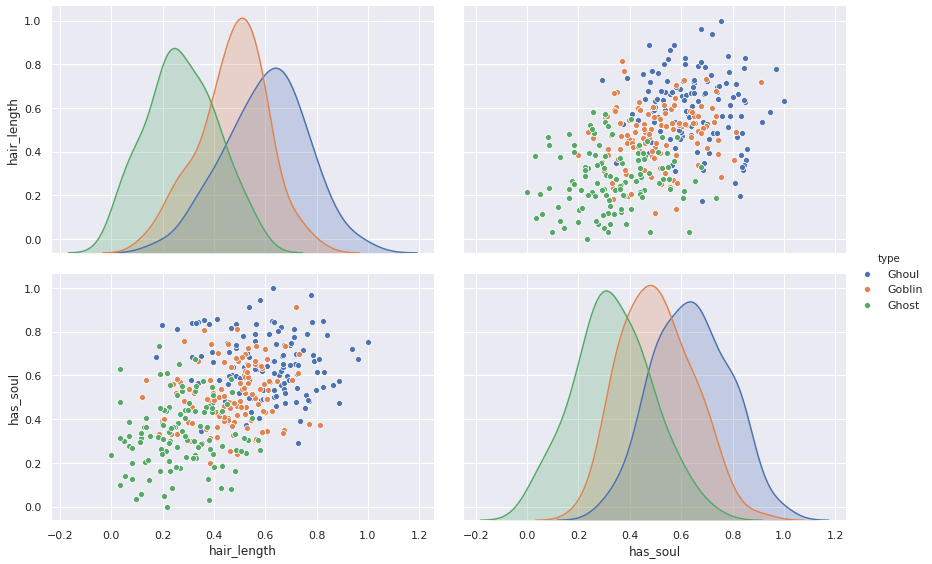

In [263]:
sns.pairplot(train_, hue='type', x_vars=[
    'hair_length',
    'has_soul',
], y_vars=[
    'hair_length',
    'has_soul',
], height=4, aspect=1.5);

# Feature Interactions

In [264]:
# define poly function for interactions
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)

# create interaction and cubic terms, including bias
poly_X = poly.fit_transform(X_)

# get column names from poly
poly_columns = poly.get_feature_names(X.columns)

fi = {}

for k,v in ensembles.items():
    fi[k] = v.fit(poly_X, y).feature_importances_

fi = pd.DataFrame.from_dict(fi, orient='index', columns=poly_columns)

fi.sort_values(fi.columns.tolist(), ascending=False, inplace=True)
fi.sort_values(fi.index.tolist(), axis=1, ascending=False, inplace=True)

fi.style.highlight_max(axis=1)

,bone_length hair_length has_soul,hair_length has_soul color_white,hair_length^2 has_soul,bone_length has_soul,has_soul^3,rotting_flesh^2 has_soul,bone_length rotting_flesh,hair_length has_soul,bone_length^2 has_soul,rotting_flesh hair_length,hair_length has_soul^2,bone_length hair_length^2,bone_length has_soul^2,bone_length^2 hair_length,rotting_flesh,rotting_flesh^3,rotting_flesh hair_length^2,bone_length,bone_length^2,bone_length rotting_flesh^2,rotting_flesh^2 hair_length,bone_length has_soul color_clear,bone_length hair_length color_white,bone_length rotting_flesh color_white,rotting_flesh hair_length color_white,rotting_flesh hair_length color_clear,bone_length hair_length color_green,bone_length hair_length color_black,bone_length hair_length,hair_length^2,hair_length,hair_length^3,has_soul^2,has_soul,bone_length rotting_flesh hair_length,rotting_flesh^2,rotting_flesh hair_length has_soul,bone_length^3,bone_length rotting_flesh has_soul,rotting_flesh has_soul^2,bone_length^2 rotting_flesh,rotting_flesh has_soul,hair_length color_white,has_soul^2 color_white,has_soul color_white,bone_length has_soul color_white,rotting_flesh color_white^2,hair_length has_soul color_clear,has_soul^2 color_clear,hair_length^2 color_white,hair_length^2 color_clear,hair_length color_white^2,bone_length^2 color_clear,hair_length color_clear^2,rotting_flesh color_white,rotting_flesh^2 color_white,has_soul color_white^2,bone_length color_white,rotting_flesh has_soul color_clear,has_soul color_clear^2,has_soul color_clear,bone_length hair_length color_clear,bone_length color_clear,rotting_flesh color_clear^2,bone_length color_white^2,hair_length color_clear,rotting_flesh^2 color_clear,bone_length color_clear^2,bone_length^2 color_white,rotting_flesh has_soul color_white,bone_length rotting_flesh color_clear,rotting_flesh color_clear,hair_length has_soul color_black,has_soul color_black^2,hair_length^2 color_green,has_soul^2 color_green,rotting_flesh color_green,hair_length has_soul color_green,has_soul^2 color_black,has_soul color_green^2,bone_length^2 color_black,hair_length color_green,rotting_flesh color_green^2,rotting_flesh color_black,hair_length color_black^2,has_soul color_black,hair_length^2 color_black,bone_length has_soul color_green,has_soul color_green,hair_length color_black,rotting_flesh^2 color_black,has_soul color_blue^2,rotting_flesh^2 color_green,hair_length color_green^2,color_white,rotting_flesh hair_length color_green,bone_length has_soul color_black,has_soul^2 color_blue,bone_length^2 color_green,bone_length color_green,rotting_flesh color_black^2,rotting_flesh has_soul color_green,bone_length has_soul color_blue,color_clear^3,bone_length rotting_flesh color_black,rotting_flesh color_blue^2,rotting_flesh hair_length color_black,color_black^3,rotting_flesh color_blue,hair_length has_soul color_blue,bone_length rotting_flesh color_green,rotting_flesh^2 color_blue,bone_length color_green^2,rotting_flesh has_soul color_blue,hair_length color_blue^2,rotting_flesh has_soul color_black,color_black,bone_length color_black,hair_length^2 color_blue,has_soul color_blue,color_clear,color_white^2,color_white^3,hair_length color_blue,color_green^2,bone_length rotting_flesh color_blue,bone_length color_black^2,color_clear^2,bone_length color_blue^2,bone_length^2 color_blue,color_blue^2,color_green,color_black^2,bone_length color_blue,bone_length hair_length color_blue,color_green^3,rotting_flesh hair_length color_blue,color_blue,hair_length color_blood^2,color_blue^3,rotting_flesh color_blood,bone_length^2 color_blood,hair_length^2 color_blood,rotting_flesh has_soul color_blood,bone_length hair_length color_blood,bone_length rotting_flesh color_blood,hair_length has_soul color_blood,hair_length color_blood,color_blood^2,has_soul^2 color_blood,has_soul color_blood,rotting_flesh color_blood^2,rotting_flesh^2 color_blood,bone_length color_blood,bone_length has_soul color_blood,rotting_flesh hair_length color_blood,has_soul color_blood^2,bon

In [265]:
# define poly function for interactions
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)

# create interaction and cubic terms, including bias
poly_X = poly.fit_transform(X_r)

# get column names from poly
poly_columns = poly.get_feature_names(X.columns)

fi = {}

for k,v in ensembles.items():
    fi[k] = v.fit(poly_X, y).feature_importances_

fi = pd.DataFrame.from_dict(fi, orient='index', columns=poly_columns)

fi.sort_values(fi.columns.tolist(), ascending=False, inplace=True)
fi.sort_values(fi.index.tolist(), axis=1, ascending=False, inplace=True)

fi.style.highlight_max(axis=1)

,hair_length^3,has_soul^3,rotting_flesh,bone_length^2 hair_length,bone_length hair_length has_soul,rotting_flesh has_soul color_white,hair_length,has_soul,bone_length,hair_length has_soul,bone_length has_soul^2,bone_length has_soul,hair_length has_soul color_white,hair_length^2 has_soul,bone_length^2 has_soul,bone_length hair_length,has_soul^2,rotting_flesh^2 hair_length,rotting_flesh^3,bone_length^3,rotting_flesh hair_length^2,has_soul color_clear,rotting_flesh has_soul^2,bone_length has_soul color_white,bone_length^2 color_clear,bone_length^2 color_white,has_soul color_green^2,hair_length has_soul^2,hair_length color_white,hair_length^2,hair_length color_white^2,rotting_flesh hair_length,bone_length hair_length^2,rotting_flesh^2 has_soul,has_soul color_white,bone_length^2,rotting_flesh has_soul,bone_length^2 rotting_flesh,bone_length rotting_flesh^2,has_soul color_clear^2,bone_length color_clear,rotting_flesh hair_length has_soul,rotting_flesh^2,bone_length rotting_flesh has_soul,bone_length rotting_flesh,bone_length color_clear^2,has_soul color_white^2,rotting_flesh color_white,hair_length color_clear^2,rotting_flesh color_white^2,bone_length rotting_flesh hair_length,bone_length color_white^2,hair_length color_clear,bone_length color_white,bone_length hair_length color_clear,has_soul^2 color_white,rotting_flesh hair_length color_white,bone_length hair_length color_white,has_soul^2 color_clear,rotting_flesh color_clear,rotting_flesh color_clear^2,rotting_flesh^2 color_white,hair_length^2 color_white,bone_length has_soul color_clear,hair_length has_soul color_clear,rotting_flesh^2 color_clear,bone_length rotting_flesh color_clear,rotting_flesh has_soul color_clear,bone_length rotting_flesh color_white,hair_length^2 color_clear,rotting_flesh hair_length color_clear,hair_length color_black^2,has_soul color_black,has_soul color_green,hair_length color_black,rotting_flesh hair_length color_black,bone_length color_black,has_soul color_black^2,color_white^3,hair_length color_green^2,bone_length color_black^2,bone_length^2 color_black,has_soul^2 color_green,bone_length color_green^2,rotting_flesh color_black,color_clear^2,hair_length color_green,bone_length rotting_flesh color_black,rotting_flesh hair_length color_green,bone_length has_soul color_green,rotting_flesh^2 color_black,rotting_flesh color_green^2,hair_length has_soul color_green,hair_length^2 color_green,color_clear,bone_length hair_length color_green,rotting_flesh color_green,rotting_flesh^2 color_green,bone_length color_green,bone_length rotting_flesh color_green,bone_length hair_length color_black,color_white,color_white^2,hair_length^2 color_black,rotting_flesh has_soul color_green,bone_length has_soul color_black,rotting_flesh color_black^2,color_clear^3,rotting_flesh has_soul color_black,bone_length^2 color_green,has_soul^2 color_black,rotting_flesh color_blue,rotting_flesh has_soul color_blue,rotting_flesh^2 color_blue,color_green,has_soul color_blue,color_black^2,color_green^3,has_soul^2 color_blue,bone_length color_blue,hair_length color_blood,color_black^3,hair_length has_soul color_black,rotting_flesh color_blue^2,rotting_flesh hair_length color_blue,hair_length color_blood^2,color_black,hair_length color_blue^2,hair_length has_soul color_blue,color_green^2,hair_length color_blue,bone_length hair_length color_blue,bone_length color_blue^2,has_soul color_blue^2,color_blood,hair_length^2 color_blue,bone_length rotting_flesh color_blue,bone_length^2 color_blue,hair_length has_soul color_blood,color_blue^2,rotting_flesh color_blood,hair_length^2 color_blood,color_blood^2,color_blue,rotting_flesh color_blood^2,rotting_flesh^2 color_blood,bone_length^2 color_blood,bone_length has_soul color_blue,rotting_flesh hair_length color_blood,bone_length color_blood^2,color_blue^3,bone_length hair_length color_blood,has_soul color_blood,has_soul color_blood^2,bone_length color_blood,bone_length has_soul color_blood,rotting_flesh has_soul color_blood,color_blood^3,bone_length 

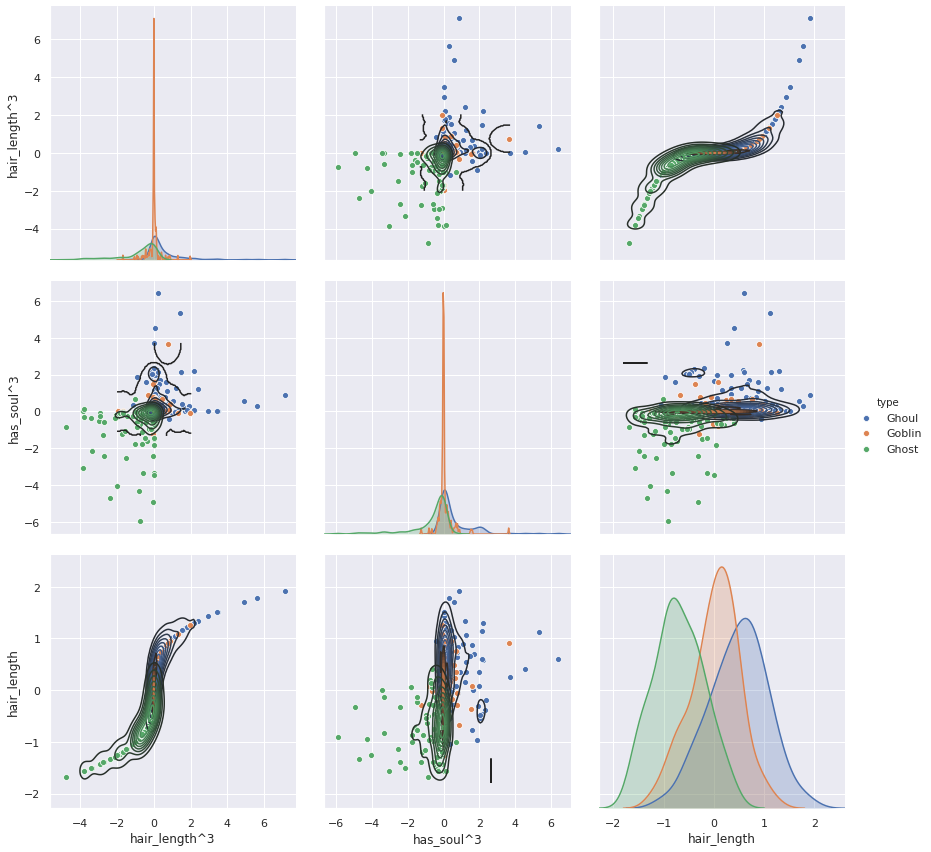

In [266]:
poly_train = pd.DataFrame(poly_X, columns=poly_columns).join(y)

g = sns.pairplot(poly_train, hue='type', x_vars=[
    'hair_length^3',
    'has_soul^3',
    'hair_length',
], y_vars=[
    'hair_length^3',
    'has_soul^3',
    'hair_length',
], height=4, aspect=1)

g.map_offdiag(sns.kdeplot);

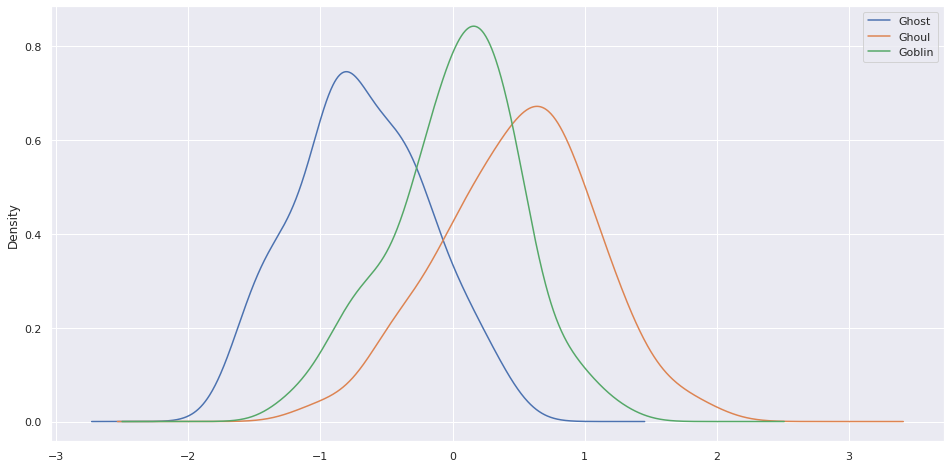

In [267]:
fig, ax = plt.subplots(figsize=(16,8))

poly_train.loc[
    poly_train.type == 'Ghost',
    'hair_length',
].plot.kde(ax=ax, label='Ghost')

poly_train.loc[
    poly_train.type == 'Ghoul',
    'hair_length',
].plot.kde(ax=ax, label='Ghoul')

poly_train.loc[
    poly_train.type == 'Goblin',
    'hair_length',
].plot.kde(ax=ax, label='Goblin')

ax.legend();

After using the `RobustScaler` and adding adding cubic interactions it can be seen that **Ghost**s' tend to have `hair_length` $\le 0$ and **Ghoul**s' have `hair_length` $\ge 0$.

**Goblin**s appear split $50$-$50$.

In [268]:
# flag if hair length < 0 (aka < median)
train['hair_length_lt0'] = (train.hair_length < train.hair_length.median()).astype(int)

# Feature Importance Part II

In [269]:
# select X features
X = train.drop(columns=[
    'id',
    'color',
    'type',
])

# select y for training
y = train.type

# define scaler
scaler = MinMaxScaler()
rscaler = RobustScaler()

# scale X
X_ = scaler.fit_transform(X)
X_r = rscaler.fit_transform(X)

# define poly function for interactions
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)

# create interaction and cubic terms, including bias
poly_X = poly.fit_transform(X_r)

# get column names from poly
poly_columns = poly.get_feature_names(X.columns)

fi = {}

for k,v in ensembles.items():
    fi[k] = v.fit(poly_X, y).feature_importances_

fi = pd.DataFrame.from_dict(fi, orient='index', columns=poly_columns)

fi.sort_values(fi.columns.tolist(), ascending=False, inplace=True)
fi.sort_values(fi.index.tolist(), axis=1, ascending=False, inplace=True)

fi.style.highlight_max(axis=1)

,has_soul,hair_length_lt0^2,hair_length hair_length_lt0,hair_length,bone_length,hair_length_lt0,hair_length^2,hair_length_lt0^3,bone_length hair_length,rotting_flesh hair_length_lt0^2,hair_length hair_length_lt0^2,hair_length^3,hair_length has_soul hair_length_lt0,hair_length^2 has_soul,has_soul^3,has_soul hair_length_lt0^2,rotting_flesh,hair_length has_soul,bone_length hair_length^2,has_soul^2,bone_length^2 has_soul,hair_length has_soul^2,rotting_flesh^3,bone_length hair_length_lt0^2,rotting_flesh hair_length_lt0,has_soul hair_length_lt0,bone_length has_soul^2,rotting_flesh hair_length,bone_length^2 hair_length,hair_length^2 hair_length_lt0,bone_length^3,bone_length^2,bone_length has_soul,bone_length^2 rotting_flesh,rotting_flesh^2,bone_length rotting_flesh^2,hair_length color_white,rotting_flesh^2 has_soul,rotting_flesh has_soul^2,rotting_flesh has_soul,bone_length color_clear^2,has_soul color_clear^2,bone_length hair_length has_soul,bone_length rotting_flesh has_soul,rotting_flesh hair_length^2,has_soul color_clear,bone_length color_clear,bone_length hair_length_lt0,has_soul color_white,rotting_flesh hair_length has_soul,rotting_flesh hair_length hair_length_lt0,bone_length rotting_flesh hair_length,bone_length rotting_flesh,hair_length color_white^2,has_soul color_white^2,rotting_flesh^2 hair_length,rotting_flesh color_white^2,has_soul^2 hair_length_lt0,hair_length has_soul color_white,bone_length hair_length hair_length_lt0,rotting_flesh color_white,hair_length color_clear,bone_length has_soul color_clear,hair_length has_soul color_clear,bone_length^2 hair_length_lt0,bone_length hair_length color_clear,rotting_flesh color_clear,bone_length hair_length color_white,rotting_flesh^2 color_white,rotting_flesh has_soul color_white,hair_length^2 color_white,rotting_flesh^2 color_clear,hair_length color_white hair_length_lt0,rotting_flesh has_soul hair_length_lt0,has_soul^2 color_clear,rotting_flesh^2 hair_length_lt0,bone_length^2 color_clear,hair_length color_clear^2,bone_length rotting_flesh hair_length_lt0,bone_length rotting_flesh color_white,bone_length color_white^2,bone_length color_white,has_soul^2 color_white,bone_length has_soul hair_length_lt0,rotting_flesh color_clear^2,bone_length^2 color_white,color_white hair_length_lt0^2,rotting_flesh has_soul color_clear,hair_length^2 color_clear,bone_length has_soul color_white,bone_length rotting_flesh color_clear,has_soul color_white hair_length_lt0,has_soul color_green^2,rotting_flesh hair_length color_clear,rotting_flesh hair_length color_white,rotting_flesh color_white hair_length_lt0,has_soul color_black,has_soul color_black^2,color_clear hair_length_lt0^2,has_soul color_clear hair_length_lt0,hair_length color_black^2,hair_length color_black,color_clear^3,has_soul color_green,bone_length color_black,bone_length^2 color_green,hair_length color_green^2,bone_length color_black^2,color_clear^2,rotting_flesh hair_length color_black,rotting_flesh^2 color_black,rotting_flesh^2 color_green,rotting_flesh has_soul color_green,has_soul^2 color_green,has_soul^2 color_black,bone_length color_green^2,bone_length color_clear hair_length_lt0,hair_length color_green,rotting_flesh color_black^2,bone_length rotting_flesh color_black,bone_length has_soul color_black,rotting_flesh has_soul color_black,bone_length rotting_flesh color_green,hair_length^2 color_black,bone_length has_soul color_green,bone_length color_white hair_length_lt0,rotting_flesh color_black,hair_length has_soul color_green,hair_length color_clear hair_length_lt0,hair_length^2 color_green,color_white^2,bone_length color_green,bone_length^2 color_black,rotting_flesh color_black hair_length_lt0,color_black^3,rotting_flesh hair_length color_green,color_white^3,rotting_flesh color_clear hair_length_lt0,hair_length has_soul color_black,color_black,color_white^2 hair_length_lt0,rotting_flesh color_blue,color_clear^2 hair_length_lt0,color_white,has_soul color_green hair_length_lt0,rotting_flesh color_green^2,rotting_flesh has_soul

`has_soul` still appears important by itself even after cubic interactions.

# EDA: `has_soul`

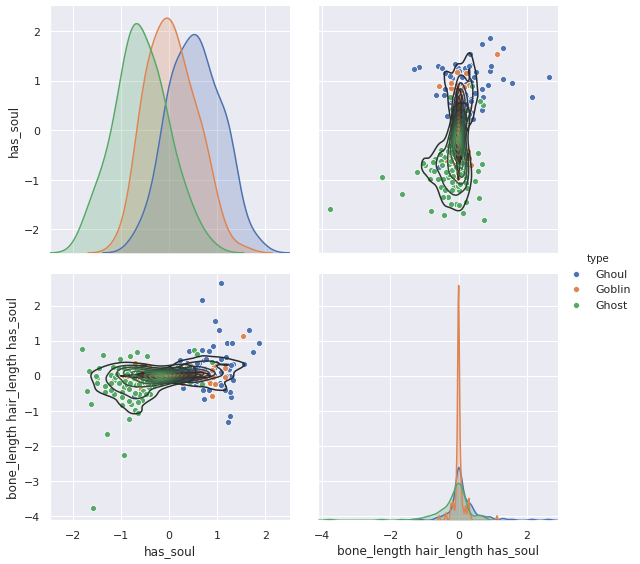

In [270]:
poly_train = pd.DataFrame(poly_X, columns=poly_columns).join(y)

g = sns.pairplot(poly_train, hue='type', x_vars=[
    'has_soul',
    'bone_length hair_length has_soul',
], y_vars=[
    'has_soul',
    'bone_length hair_length has_soul',
], height=4, aspect=1)

g.map_offdiag(sns.kdeplot);

Seems to be a similar situation for `has_soul`:
- **Ghost**s are $\le 0$
- **Ghoul**s are $\ge 0$
- **Goblin**s are split $50$-$50$

In [271]:
# flag if has soul < 0 (aka < median)
train['has_soul_lt0'] = (train.has_soul < train.has_soul.median()).astype(int)

In [272]:
# counts by combination of hair_length_lt0 and has_soul_lt0
train.groupby([
    'hair_length_lt0',
    'has_soul_lt0',
    'type',
]).id.count().unstack()

type                          Ghost  Ghoul  Goblin
hair_length_lt0 has_soul_lt0                      
0               0                 2     87      41
                1                11     16      29
1               0                15     20      21
                1                89      6      34

# Feature Importance: Part III

In [284]:
# select X features
X = train.drop(columns=[
    'id',
    'color',
    'type',
])

# select y for training
y = train.type

# define scaler
scaler = MinMaxScaler()
rscaler = RobustScaler()

# scale X
X_ = scaler.fit_transform(X)
X_r = rscaler.fit_transform(X)

# define poly function for interactions
poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)

# create interaction and cubic terms, including bias
poly_X = poly.fit_transform(X_r)

# get column names from poly
poly_columns = poly.get_feature_names(X.columns)

fi = {}

for k,v in ensembles.items():
    fi[k] = v.fit(poly_X, y).feature_importances_

fi = pd.DataFrame.from_dict(fi, orient='index', columns=poly_columns)

fi.sort_values(fi.columns.tolist(), ascending=False, inplace=True)
fi.sort_values(fi.index.tolist(), axis=1, ascending=False, inplace=True)

fi.style.highlight_max(axis=1)

,bone_length,hair_length,has_soul,rotting_flesh,rotting_flesh hair_length hair_length_lt0,has_soul has_soul_lt0,hair_length has_soul hair_length_lt0,bone_length hair_length has_soul,rotting_flesh hair_length has_soul,hair_length has_soul,hair_length has_soul_lt0,bone_length hair_length_lt0,bone_length hair_length hair_length_lt0,rotting_flesh has_soul has_soul_lt0,bone_length has_soul has_soul_lt0,hair_length hair_length_lt0,rotting_flesh has_soul hair_length_lt0,bone_length has_soul color_clear,bone_length hair_length has_soul_lt0,bone_length color_clear,hair_length has_soul color_clear,rotting_flesh has_soul color_white,bone_length color_white,hair_length color_white hair_length_lt0,bone_length has_soul color_green,hair_length color_clear hair_length_lt0,rotting_flesh hair_length color_green,bone_length color_white has_soul_lt0,has_soul color_black,hair_length color_blood,hair_length hair_length_lt0 has_soul_lt0,bone_length hair_length,bone_length has_soul,rotting_flesh hair_length_lt0,rotting_flesh has_soul,has_soul hair_length_lt0,hair_length has_soul has_soul_lt0,bone_length rotting_flesh has_soul,bone_length rotting_flesh hair_length,rotting_flesh hair_length,rotting_flesh hair_length_lt0 has_soul_lt0,bone_length has_soul_lt0,rotting_flesh has_soul_lt0,bone_length has_soul hair_length_lt0,bone_length rotting_flesh,has_soul hair_length_lt0 has_soul_lt0,bone_length rotting_flesh has_soul_lt0,hair_length color_white,has_soul color_clear,bone_length hair_length color_clear,rotting_flesh color_white,has_soul color_white,bone_length rotting_flesh color_white,has_soul_lt0,hair_length has_soul color_white,rotting_flesh hair_length has_soul_lt0,bone_length rotting_flesh hair_length_lt0,bone_length has_soul color_white,bone_length hair_length color_white,hair_length color_clear,rotting_flesh hair_length color_clear,rotting_flesh hair_length color_white,bone_length hair_length_lt0 has_soul_lt0,rotting_flesh color_clear,bone_length rotting_flesh color_clear,hair_length_lt0,hair_length_lt0 has_soul_lt0,rotting_flesh has_soul color_clear,rotting_flesh color_white hair_length_lt0,rotting_flesh color_white has_soul_lt0,has_soul color_white hair_length_lt0,has_soul color_clear has_soul_lt0,bone_length color_clear has_soul_lt0,rotting_flesh color_clear has_soul_lt0,has_soul color_clear hair_length_lt0,hair_length has_soul color_black,rotting_flesh has_soul color_green,has_soul color_green,bone_length color_black,hair_length color_white has_soul_lt0,bone_length rotting_flesh color_black,bone_length color_green,has_soul color_white has_soul_lt0,hair_length color_black,rotting_flesh color_green,bone_length hair_length color_green,rotting_flesh has_soul color_blue,bone_length rotting_flesh color_green,hair_length has_soul color_green,rotting_flesh color_black,hair_length color_green,bone_length hair_length color_black,bone_length color_white hair_length_lt0,rotting_flesh hair_length color_black,hair_length color_clear has_soul_lt0,rotting_flesh color_blue,hair_length color_blue,rotting_flesh color_clear hair_length_lt0,bone_length color_clear hair_length_lt0,bone_length has_soul color_black,rotting_flesh hair_length color_blue,hair_length has_soul color_blue,color_white hair_length_lt0,rotting_flesh has_soul color_black,hair_length color_green hair_length_lt0,color_white has_soul_lt0,rotting_flesh color_green hair_length_lt0,has_soul color_blue,color_white,bone_length color_green hair_length_lt0,rotting_flesh color_green has_soul_lt0,color_white hair_length_lt0 has_soul_lt0,has_soul color_green has_soul_lt0,color_clear,hair_length color_green has_soul_lt0,bone_length has_soul color_blue,bone_length color_green has_soul_lt0,has_soul color_blue hair_length_lt0,bone_length rotting_flesh color_blue,bone_length color_black has_soul_lt0,bone_length color_blue,bone_length color_black hair_length_lt0,has_soul color_green hair_length_lt0,bone_length color_blood,bone_length color_blue hair_length_lt0,has_soul color_black hair_length_lt0,has_soul color_

After adding the two flags, `bone_length` has shown some promise with quadratic and cubic interactions (when limiting to interaction only).

# EDA: `bone_length`

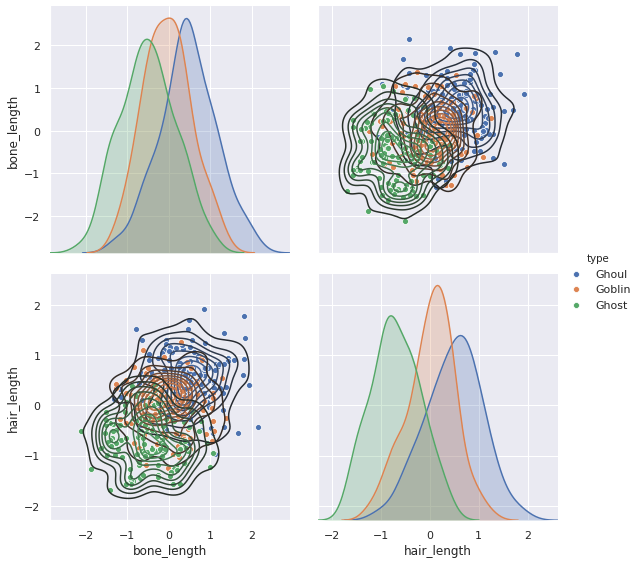

In [285]:
poly_train = pd.DataFrame(poly_X, columns=poly_columns).join(y)

g = sns.pairplot(poly_train, hue='type', x_vars=[
    'bone_length',
    'hair_length',
], y_vars=[
    'bone_length',
    'hair_length',
], height=4, aspect=1)

g.map_offdiag(sns.kdeplot);

Similar situation:
- **Ghost**s `bone_length` $\le 0$
- **Ghoul**s `bone_length` $\ge 0$
- **Goblin**s split $50$-$50$

In [286]:
# flag if bone length < 0 (aka < median)
train['bone_length_lt0'] = (train.bone_length < train.bone_length.median()).astype(int)

In [287]:
# counts by combination of hair_length_lt0, has_soul_lt0, and bone_length_lt0
train.groupby([
    'hair_length_lt0',
    'has_soul_lt0',
    'bone_length_lt0',
    'type',
]).id.count().unstack()

type                                          Ghost  Ghoul  Goblin
hair_length_lt0 has_soul_lt0 bone_length_lt0                      
0               0            0                  NaN   70.0    22.0
                             1                  2.0   17.0    19.0
                1            0                  NaN   12.0    14.0
                             1                 11.0    4.0    15.0
1               0            0                  2.0   14.0    10.0
                             1                 13.0    6.0    11.0
                1            0                 25.0    3.0    14.0
                             1                 64.0    3.0    20.0

- **Ghoul**s tend to be above the median on `hair_length`, `has_soul`, and `bone_length`.
- **Ghost**s tend to be below the median on `hair_length`, `has_soul`, and `bone_length`.
- **Goblin**s tend to be at the extremes (all above or all below).

In [299]:
# sum hair_length_lt0, has_soul_lt0, bone_length_lt0 flags
train['lt0_sum_hair_soul_bone'] = train.hair_length_lt0 + train.has_soul_lt0 + train.bone_length_lt0

In [301]:
# counts by lt0_sum_hair_soul_bone
train.groupby([
    'lt0_sum_hair_soul_bone',
    'type',
]).id.count().unstack()

type,Ghost,Ghoul,Goblin
lt0_sum_hair_soul_bone,,,
0,NaN,70.0,22.0
1,4.0,43.0,43.0
2,49.0,13.0,40.0
3,64.0,3.0,20.0


# Feature Importance Part IV

In [314]:
# select X features
X = train.drop(columns=[
    'id',
    'color',
    'type',
])

# select y for training
y = train.type

# define scaler
scaler = MinMaxScaler()
rscaler = RobustScaler()

# scale X
X_ = scaler.fit_transform(X)
X_r = rscaler.fit_transform(X)

# define poly function for interactions
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# create interaction and cubic terms, including bias
poly_X = poly.fit_transform(X_r)

# get column names from poly
poly_columns = poly.get_feature_names(X.columns)

fi = {}

for k,v in ensembles.items():
    fi[k] = v.fit(poly_X, y).feature_importances_

fi = pd.DataFrame.from_dict(fi, orient='index', columns=poly_columns)

fi.sort_values(fi.columns.tolist(), ascending=False, inplace=True)
fi.sort_values(fi.index.tolist(), axis=1, ascending=False, inplace=True)

fi.style.highlight_max(axis=1)

,rotting_flesh,has_soul has_soul_lt0,hair_length,hair_length hair_length_lt0,has_soul,hair_length lt0_sum_hair_soul_bone,bone_length,bone_length has_soul,hair_length has_soul_lt0,has_soul bone_length_lt0,bone_length^2,rotting_flesh bone_length_lt0,has_soul color_clear,lt0_sum_hair_soul_bone,has_soul hair_length_lt0,bone_length hair_length,rotting_flesh hair_length,has_soul^2,hair_length^2,rotting_flesh lt0_sum_hair_soul_bone,bone_length rotting_flesh,bone_length lt0_sum_hair_soul_bone,bone_length bone_length_lt0,bone_length hair_length_lt0,has_soul color_white,bone_length color_white,rotting_flesh color_green,hair_length color_green,color_white,hair_length color_blood,rotting_flesh has_soul_lt0,hair_length has_soul,rotting_flesh hair_length_lt0,rotting_flesh has_soul,hair_length bone_length_lt0,rotting_flesh^2,has_soul lt0_sum_hair_soul_bone,bone_length has_soul_lt0,has_soul_lt0,hair_length color_white,hair_length_lt0^2,bone_length color_clear,rotting_flesh color_white,lt0_sum_hair_soul_bone^2,rotting_flesh color_clear,hair_length color_clear,hair_length_lt0 has_soul_lt0,has_soul_lt0^2,hair_length_lt0,bone_length_lt0,color_white lt0_sum_hair_soul_bone,bone_length_lt0^2,has_soul_lt0 bone_length_lt0,color_clear lt0_sum_hair_soul_bone,has_soul color_green,bone_length color_black,hair_length_lt0 bone_length_lt0,hair_length_lt0 lt0_sum_hair_soul_bone,has_soul_lt0 lt0_sum_hair_soul_bone,rotting_flesh color_black,color_clear bone_length_lt0,hair_length color_black,has_soul color_black,bone_length color_green,has_soul color_blue,color_clear has_soul_lt0,rotting_flesh color_blue,color_clear^2,hair_length color_blue,color_black^2,color_blue lt0_sum_hair_soul_bone,color_black lt0_sum_hair_soul_bone,color_green,color_green lt0_sum_hair_soul_bone,color_green bone_length_lt0,color_clear,color_white^2,color_clear hair_length_lt0,color_black hair_length_lt0,color_blue^2,bone_length color_blue,color_white bone_length_lt0,color_green^2,color_black,color_black bone_length_lt0,bone_length color_blood,color_black has_soul_lt0,color_white hair_length_lt0,has_soul color_blood,bone_length_lt0 lt0_sum_hair_soul_bone,rotting_flesh color_blood,color_green hair_length_lt0,color_blue,color_blood,color_blood hair_length_lt0,color_white has_soul_lt0,color_blue hair_length_lt0,color_blood has_soul_lt0,color_green has_soul_lt0,color_blue has_soul_lt0,color_blood lt0_sum_hair_soul_bone,color_blood^2,color_blood bone_length_lt0,color_blue bone_length_lt0,color_black color_blood,color_black color_blue,color_black color_clear,color_black color_green,color_black color_white,color_blood color_blue,color_blood color_clear,color_blood color_green,color_blood color_white,color_blue color_clear,color_blue color_green,color_blue color_white,color_clear color_green,color_clear color_white,color_green color_white
AdaBoostClassifier,0.1,0.08,0.06,0.06,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
RandomForestClassifier,0.0251033,0.025419,0.0580622,0.031387,0.0420354,0.032731,0.0266091,0.0257334,0.0257223,0.0233277,0.0187671,0.0170998,0.00938001,0.0427119,0.0333628,0.0252719,0.0244797,0.0237084,0.0203782,0.0185256,0.0180308,0.0163146,0.0148359,0.0119472,0.0111817,0.00750137,0.00438355,0.00311532,0.00185006,0.000766398,0.0319628,0.0318925,0.0311201,0.0248008,0.0205494,0.0175138,0.0170464,0.0121027,0.0118753,0.0114149,0.0112345,0.00971706,0.00940601,0.00937074,0.00843966,0.00649041,0.00584808,0.00544904,0.00488799,0.00340796,0.00336239,0.00331143,0.00315212,0.00314538,0.00296595,0.00290868,0.00282083,0.0028086,0.00271001,0.00264646,0.0025929,0.00250616,0.00246533,0.00217939,0.00216912,0.00204389,0.00203676,0.00199058,0.00184563,0.00169835,0.0016676,0.0013941,0.00130866,0.00130656,0.00128918,0.00120818,0.00120023,0.0010

`rotting_flesh` has popped up in a few places:
- `rotting_flesh^2 lt0_sum_hair_soul_bone` with cubic interaction
- `rotting_flesh` with quadratic interaction
- `rotting_flesh` with no interaction

# EDA: `rotting_flesh`

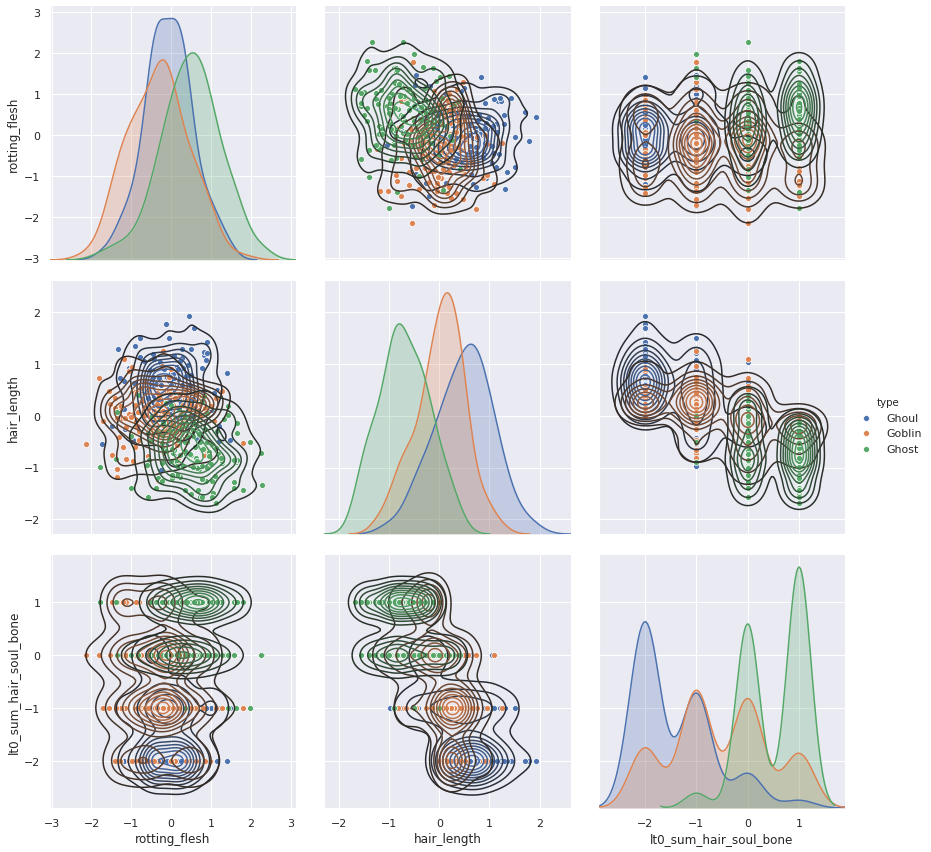

In [315]:
poly_train = pd.DataFrame(poly_X, columns=poly_columns).join(y)

g = sns.pairplot(poly_train, hue='type', x_vars=[
    'rotting_flesh',
    'hair_length',
    'lt0_sum_hair_soul_bone',
], y_vars=[
    'rotting_flesh',
    'hair_length',
    'lt0_sum_hair_soul_bone',
], height=4, aspect=1)

g.map_offdiag(sns.kdeplot);